In [1]:
#General modules
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing modules
import string
import re
import nltk
nltk.download('punkt')

# ML modules
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Preprocessing functions
def text_preprocessing(text, stop_words):
    """
    Performs tokenization and simple preprocessing.
    Args : 
        @param text (String): Text that needs preprocessing
        @return: text (String) : Preprocessed text
    """
    bad_symbols = re.compile('[/(){}\[\]\|@,;+_#]')
    fine_symbols = re.compile('[^0-9абвгдѓежзѕијклљмнњопрстќуфхцчџш ]')
    stopwords_set = stop_words
    lat_to_cyr = {'kj':'ќ', 'gj':'ѓ', 'zh':'ж', 'ch':'ч', 'sh':'ш', 'dj':'ѓ', 'nj':'љ', 'lj':'љ',
              'a':'а', 'b':'б', 'c':'ц', 'd':'д', 'e':'е', 'f':'ф', 'g':'г',
              'h':'х', 'i':'и', 'j':'ј', 'k':'к', 'l':'л', 'm':'м', 'n':'н', 
              'o':'о', 'p':'п', 'q':'љ', 'r':'р', 's':'с', 't':'т', 'u':'у',
              'v':'в', 'w':'њ', 'x':'џ', 'y':'ѕ', 'z':'з'
             }
    
    text = text.lower()
    
    for item, value in lat_to_cyr.items():
        text = re.sub(item, value, text)
    
    text = bad_symbols.sub(' ', text)

    text = fine_symbols.sub('', text)
    
    text = ' '.join([x for x in text.split() if x and x not in stopwords_set])

    return text.strip()



# Load the dataset
def load_dataset(source):
    # Loading the data from the source
    data = pd.read_csv(source)

    # Spliting into questions, answers and categories
    questions = data.iloc[:, 0]
    answers = data.iloc[:, 1]
    categories = data.iloc[:, 2]
    category_codes = data.iloc[:, 3]
    
    return questions, answers, categories, category_codes


# Load the stop words
def load_stop_words(source):
    file = open(source, 'r')
    sw=file.read().split()
    file.close()
    return sw

[nltk_data] Downloading package punkt to /home/filip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Loading the database of questions and building the corpus
qus, ans, cat, cat_codes = load_dataset('dataset_brainster.csv')
sw = load_stop_words('stop_words.txt')

corpus = [text_preprocessing(q, sw) for q in qus]

In [3]:
len(cat_codes)

523

In [4]:
# Builting the Count-Vectorized features
count_vectorizer = CountVectorizer(strip_accents='unicode') #probaj bez max_features
count_vectorizer.fit(corpus)
corpus_vec = count_vectorizer.transform(corpus)

corpus_vec_df = pd.DataFrame(data = corpus_vec.todense(), columns = count_vectorizer.get_feature_names())

In [5]:
corpus_vec_df.shape

(523, 499)

In [6]:
# Building the TF-IDF Vectorized Features
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode')
tfidf_vectorizer.fit(corpus)
corpus_tfidif = tfidf_vectorizer.transform(corpus)

corpus_tfidif_df = pd.DataFrame(data = corpus_tfidif.todense(), columns = tfidf_vectorizer.get_feature_names())

In [7]:
corpus_tfidif_df.shape

(523, 499)

## Testing CountVectorizer

In [8]:
# Defining Cosine Similarity Functiom
def cos_sim(new_input, corpus): 
    cosine_function = lambda a, b : np.inner(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    distances = []
    for question in corpus:
        distances.append(cosine_function(new_input.toarray(), question.toarray()))
    max_sim = max(max(max(distances)))
    max_arg = np.argmax(distances)
    return max_arg, max_sim, distances

In [9]:
# Defining Pearson Similarity Function
def pearson_sim(new_input, corpus): 
    distances = []
    for question in corpus:
        distances.append(np.corrcoef(new_input.todense(), question.todense())[0, 1])
    max_sim = max(distances)
    max_arg = np.argmax(distances)
    return max_arg, max_sim, distances

In [10]:
# Defining Dice Similarity Function
def dice_sim(new_input, corpus):
    new_input = new_input.toarray().flatten().astype(bool)
    distances = []
    for question in corpus:
        question = question.toarray().flatten().astype(bool)
        distances.append(2.0*np.logical_and(new_input, question).sum()/(new_input.sum() + question.sum()))
    max_sim = max(distances)
    max_arg = np.argmax(distances)
    return max_arg, max_sim, distances

In [11]:
tq = 'се прифаќа ли ваучер од владата'
tq = text_preprocessing(tq, sw)
tq = count_vectorizer.transform([tq])

In [12]:
# Getting the closest cosine-score and responding
max_arg, max_sim, distances = cos_sim(tq, corpus_vec)

print(max_arg)

print(max_sim)

print('Најблиску до прашањето:', qus[max_arg])
print('Одговор: ', ans[max_arg])

376
0.4999999999999999
Најблиску до прашањето: како да аплицирам за ваучер
Одговор:  Најпрво избери ја обуката за која сакаш да го искористиш ваучерот, резервирај го твоето место на истата, а нашиот тим ќе ти помогне во целиот процес на апликација за ваучерот. Дополнително може да се информираш на следниот лник https://vauceri.brainster.co/upatstvo/


In [13]:
# Getting the closest pearson-score and responding
max_arg, max_sim, distances = pearson_sim(tq, corpus_vec)

print(max_arg)

print(max_sim)

print('Најблиску до прашањето:', qus[max_arg])
print('Одговор: ', ans[max_arg])

376
0.49798792756539395
Најблиску до прашањето: како да аплицирам за ваучер
Одговор:  Најпрво избери ја обуката за која сакаш да го искористиш ваучерот, резервирај го твоето место на истата, а нашиот тим ќе ти помогне во целиот процес на апликација за ваучерот. Дополнително може да се информираш на следниот лник https://vauceri.brainster.co/upatstvo/


In [14]:
# Getting the closest dice-score and responding
max_arg, max_sim, distances = dice_sim(tq, corpus_vec)

print(max_arg)

print(max_sim)

print('Најблиску до прашањето:', qus[max_arg])
print('Одговор: ', ans[max_arg])

376
0.5
Најблиску до прашањето: како да аплицирам за ваучер
Одговор:  Најпрво избери ја обуката за која сакаш да го искористиш ваучерот, резервирај го твоето место на истата, а нашиот тим ќе ти помогне во целиот процес на апликација за ваучерот. Дополнително може да се информираш на следниот лник https://vauceri.brainster.co/upatstvo/


## Testing TF-IDF Vectorizer

In [15]:
tq = 'се прифаќа ли ваучер од владата'
tq = text_preprocessing(tq, sw)
tq = tfidf_vectorizer.transform([tq])

In [16]:
# Getting the closest cosine-score and responding
max_arg, max_sim, distances = cos_sim(tq, corpus_tfidif)

print(max_arg)

print(max_sim)

print('Најблиску до прашањето:', qus[max_arg])
print('Одговор: ', ans[max_arg])

376
0.6176566731622903
Најблиску до прашањето: како да аплицирам за ваучер
Одговор:  Најпрво избери ја обуката за која сакаш да го искористиш ваучерот, резервирај го твоето место на истата, а нашиот тим ќе ти помогне во целиот процес на апликација за ваучерот. Дополнително може да се информираш на следниот лник https://vauceri.brainster.co/upatstvo/


In [17]:
# Getting the closest pearson-score and responding
max_arg, max_sim, distances = pearson_sim(tq, corpus_tfidif)

print(max_arg)

print(max_sim)

print('Најблиску до прашањето:', qus[max_arg])
print('Одговор: ', ans[max_arg])

376
0.6161442349675342
Најблиску до прашањето: како да аплицирам за ваучер
Одговор:  Најпрво избери ја обуката за која сакаш да го искористиш ваучерот, резервирај го твоето место на истата, а нашиот тим ќе ти помогне во целиот процес на апликација за ваучерот. Дополнително може да се информираш на следниот лник https://vauceri.brainster.co/upatstvo/


In [18]:
# Getting the closest dice-score and responding
max_arg, max_sim, distances = dice_sim(tq, corpus_tfidif)

print(max_arg)

print(max_sim)

print('Најблиску до прашањето:', qus[max_arg])
print('Одговор: ', ans[max_arg])

376
0.5
Најблиску до прашањето: како да аплицирам за ваучер
Одговор:  Најпрво избери ја обуката за која сакаш да го искористиш ваучерот, резервирај го твоето место на истата, а нашиот тим ќе ти помогне во целиот процес на апликација за ваучерот. Дополнително може да се информираш на следниот лник https://vauceri.brainster.co/upatstvo/


## Building the WordEmbeddings

In [19]:
# Loading modules
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

#Building the embedding corpus
corpus_embedding = [question.split() for question in corpus]

corpus_embedding[:2]

In [20]:
word_to_int = Tokenizer(
    num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n„“', lower=True,
    split=' ', char_level=False, oov_token=None, document_count=0)


text_int = word_to_int.fit_on_texts(corpus)

text_int = word_to_int.texts_to_sequences(corpus)
text_int[0]

[36, 42, 1, 12, 11]

In [21]:
corpus[0]

'време трае академијата дигитален маркетинг'

In [22]:
max(max(text_int))

500

In [23]:
# Loading word embeddings for Macedonian
from bpemb import BPEmb
bpemb_mk = BPEmb(lang="mk", dim=300)

In [24]:
%time
# Embedding our corpus
embedded_corpus = []
for question in corpus:
    embedded_corpus.append(bpemb_mk.embed(question).mean(axis = 0))

embedded_corpus = np.array(embedded_corpus)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


# Класификатори за категорија

In [25]:
# Preparing the tagtets (category codes)
cat_codes = np.array(cat_codes)

In [26]:
# Implementing classifiers
# RF, NaiveBayes, NearNeigh, SVC

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.model_selection import train_test_split, cross_val_score

In [27]:
def plot_confusion_matrix(y_test, y_pred, axis_labels, title):
    plt.figure()
    ax=sns.heatmap(confusion_matrix(y_test, y_pred),
                   annot = True,
                   cmap='Greens')
    ax.set(xlabel='True', ylabel='Predicted')
    ax.set_xticklabels(axis_labels, rotation=30)
    ax.set_yticklabels(axis_labels, rotation=0)
    ax.set_title(title)
    plt.show()

## Word Embeddings Classifiers

In [28]:
# Splitting the data into train and test:

X_train, X_test, y_train, y_test = train_test_split(embedded_corpus, cat_codes,
                                                    train_size=0.8,
                                                    random_state=10)

cat_labels = ['општо', 'маркетинг', 'дизајн', 'програмирање', 'Data Science', 'Soft. Test.', 'UX/UI']

In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(418, 300)
(105, 300)
(418,)
(105,)


              precision    recall  f1-score   support

       општо       0.50      0.25      0.33         4
   маркетинг       0.83      1.00      0.91         5
      дизајн       1.00      0.92      0.96        26
програмирање       0.73      0.93      0.82        29
Data Science       1.00      0.89      0.94        18
 Soft. Test.       0.89      0.73      0.80        11
       UX/UI       0.91      0.83      0.87        12

    accuracy                           0.87       105
   macro avg       0.84      0.79      0.80       105
weighted avg       0.88      0.87      0.86       105



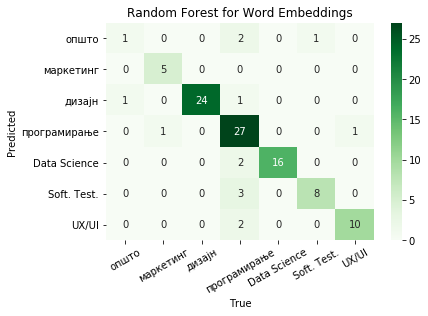

In [30]:
# Building the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=10)

rf_classifier.fit(X_train, y_train)

rf_pred = rf_classifier.predict(X_test)

#Printing the classification report
rf_class_report = classification_report(y_test, rf_pred, target_names=cat_labels)
print(rf_class_report)

#confusion_matrix()
plot_confusion_matrix(y_test, rf_pred, cat_labels, 'Random Forest for Word Embeddings')

              precision    recall  f1-score   support

       општо       0.67      0.50      0.57         4
   маркетинг       0.71      1.00      0.83         5
      дизајн       1.00      0.92      0.96        26
програмирање       0.76      0.97      0.85        29
Data Science       1.00      0.83      0.91        18
 Soft. Test.       1.00      0.82      0.90        11
       UX/UI       1.00      0.83      0.91        12

    accuracy                           0.89       105
   macro avg       0.88      0.84      0.85       105
weighted avg       0.91      0.89      0.89       105



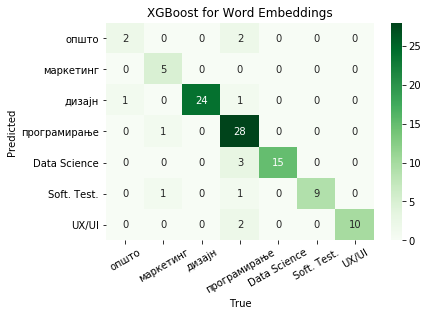

In [31]:
import xgboost as xgb

# Building the Random Forest Classifier
xgb_classifier = xgb.XGBClassifier()

xgb_classifier.fit(X_train, y_train)

xgb_pred = xgb_classifier.predict(X_test)

#Printing the classification report
xgb_class_report = classification_report(y_test, xgb_pred, target_names=cat_labels)
print(xgb_class_report)

#confusion_matrix()
plot_confusion_matrix(y_test, xgb_pred, cat_labels, 'XGBoost for Word Embeddings')

              precision    recall  f1-score   support

           0       0.21      0.75      0.33         4
           1       0.83      1.00      0.91         5
           2       1.00      0.88      0.94        26
           3       0.80      0.69      0.74        29
           4       1.00      0.89      0.94        18
           5       1.00      0.82      0.90        11
           6       1.00      1.00      1.00        12

    accuracy                           0.84       105
   macro avg       0.84      0.86      0.82       105
weighted avg       0.91      0.84      0.86       105



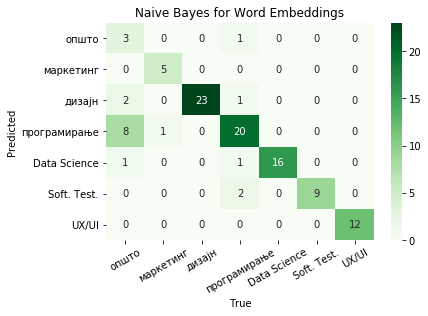

In [32]:
# Building the Naive Bayes Classifier
bayes_classifier = BernoulliNB()

bayes_classifier.fit(X_train, y_train)

bayes_pred = bayes_classifier.predict(X_test)

#Printing the classification report
bayes_class_report = classification_report(y_test, bayes_pred)
print(bayes_class_report)

#confusion_matrix()
plot_confusion_matrix(y_test, bayes_pred, cat_labels, 'Naive Bayes for Word Embeddings')

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.71      1.00      0.83         5
           2       0.92      0.92      0.92        26
           3       0.89      0.83      0.86        29
           4       0.86      1.00      0.92        18
           5       0.89      0.73      0.80        11
           6       0.92      0.92      0.92        12

    accuracy                           0.88       105
   macro avg       0.84      0.84      0.83       105
weighted avg       0.88      0.88      0.87       105



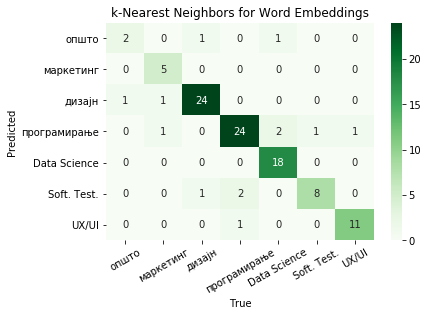

In [33]:
# Building the KNearest Neighbors Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3,
                                    weights='distance',
                                    p=2,
                                    n_jobs=-1)

knn_classifier.fit(X_train, y_train)

knn_pred = knn_classifier.predict(X_test)

#Printing the classification report
knn_class_report = classification_report(y_test, knn_pred)
print(knn_class_report)

#confusion_matrix()
plot_confusion_matrix(y_test, knn_pred, cat_labels, 'k-Nearest Neighbors for Word Embeddings')

              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       1.00      1.00      1.00         5
           2       1.00      0.92      0.96        26
           3       0.80      0.97      0.88        29
           4       1.00      0.94      0.97        18
           5       1.00      0.82      0.90        11
           6       1.00      1.00      1.00        12

    accuracy                           0.91       105
   macro avg       0.88      0.84      0.86       105
weighted avg       0.92      0.91      0.91       105



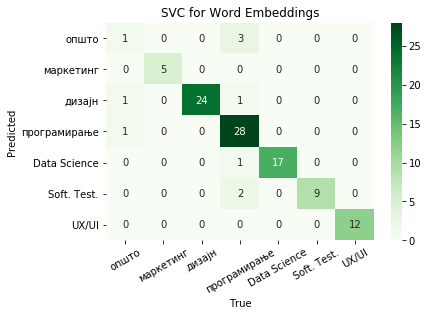

In [34]:
# Building the Support Vector Classifier
svc_classifier = SVC(kernel='rbf', random_state=10)

svc_classifier.fit(X_train, y_train)

svc_pred = svc_classifier.predict(X_test)

#Printing the classification report
svc_class_report = classification_report(y_test, svc_pred)
print(svc_class_report)

#confusion_matrix()
plot_confusion_matrix(y_test, svc_pred, cat_labels, 'SVC for Word Embeddings')

              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.83      1.00      0.91         5
           2       1.00      0.92      0.96        26
           3       0.67      0.90      0.76        29
           4       1.00      0.67      0.80        18
           5       0.90      0.82      0.86        11
           6       0.82      0.75      0.78        12

    accuracy                           0.82       105
   macro avg       0.79      0.76      0.77       105
weighted avg       0.84      0.82      0.82       105



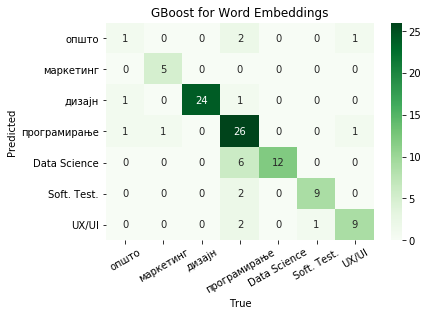

In [35]:
# Building the Gradient Boost Classifier
gb_classifier = GradientBoostingClassifier(learning_rate=0.2,
                                          min_samples_leaf=1,
                                          max_depth=5,
                                          random_state=10)

gb_classifier.fit(X_train, y_train)

gb_pred = gb_classifier.predict(X_test)

#Printing the classification report
gb_class_report = classification_report(y_test, gb_pred)
print(gb_class_report)

#confusion_matrix()
plot_confusion_matrix(y_test, gb_pred, cat_labels, 'GBoost for Word Embeddings')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.31      1.00      0.48         5
           2       1.00      0.81      0.89        26
           3       0.68      0.79      0.73        29
           4       1.00      0.67      0.80        18
           5       0.78      0.64      0.70        11
           6       0.83      0.83      0.83        12

    accuracy                           0.74       105
   macro avg       0.66      0.68      0.63       105
weighted avg       0.80      0.74      0.75       105



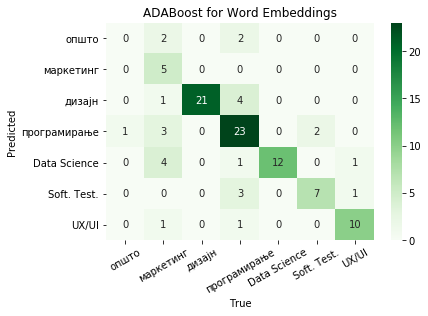

In [36]:
# Building the ADABoost Classifier
ada_classifier = AdaBoostClassifier(n_estimators=100,
                                   learning_rate=0.3,
                                   random_state=10)

ada_classifier.fit(X_train, y_train)

ada_pred = ada_classifier.predict(X_test)

#Printing the classification report
ada_class_report = classification_report(y_test, ada_pred)
print(ada_class_report)

#confusion_matrix()
plot_confusion_matrix(y_test, ada_pred, cat_labels, 'ADABoost for Word Embeddings')

## Count Vectorizer Classifiers

In [37]:
# Splitting the data into train and test:

X_train, X_test, y_train, y_test = train_test_split(corpus_vec, cat_codes,
                                                    train_size=0.8,
                                                    random_state=10)

              precision    recall  f1-score   support

       општо       0.33      0.50      0.40         4
   маркетинг       1.00      1.00      1.00         5
      дизајн       1.00      0.96      0.98        26
програмирање       0.87      0.93      0.90        29
Data Science       1.00      0.94      0.97        18
 Soft. Test.       1.00      0.82      0.90        11
       UX/UI       1.00      1.00      1.00        12

    accuracy                           0.92       105
   macro avg       0.89      0.88      0.88       105
weighted avg       0.94      0.92      0.93       105



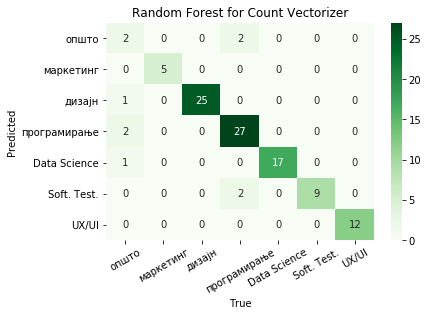

In [38]:
# Building the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=10)

rf_classifier.fit(X_train, y_train)

rf_pred = rf_classifier.predict(X_test)

#Printing the classification report
rf_class_report = classification_report(y_test, rf_pred, target_names=cat_labels)
print(rf_class_report)

#confusion_matrix()
plot_confusion_matrix(y_test, rf_pred, cat_labels, 'Random Forest for Count Vectorizer')

              precision    recall  f1-score   support

       општо       0.43      0.75      0.55         4
   маркетинг       1.00      1.00      1.00         5
      дизајн       1.00      0.96      0.98        26
програмирање       0.87      0.90      0.88        29
Data Science       1.00      0.94      0.97        18
 Soft. Test.       1.00      0.82      0.90        11
       UX/UI       1.00      1.00      1.00        12

    accuracy                           0.92       105
   macro avg       0.90      0.91      0.90       105
weighted avg       0.94      0.92      0.93       105



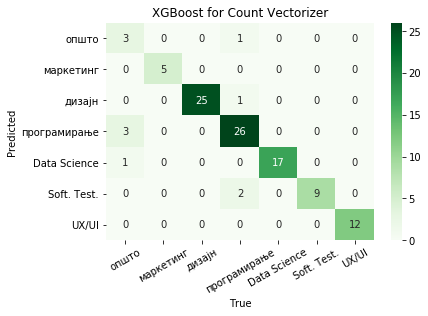

In [39]:
import xgboost as xgb

# Building the Random Forest Classifier
xgb_classifier = xgb.XGBClassifier()

xgb_classifier.fit(X_train, y_train)

xgb_pred = xgb_classifier.predict(X_test)

#Printing the classification report
xgb_class_report = classification_report(y_test, xgb_pred, target_names=cat_labels)
print(xgb_class_report)

#confusion_matrix()
plot_confusion_matrix(y_test, xgb_pred, cat_labels, 'XGBoost for Count Vectorizer')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      0.80      0.89         5
           2       1.00      0.88      0.94        26
           3       0.68      0.93      0.78        29
           4       1.00      0.83      0.91        18
           5       1.00      0.82      0.90        11
           6       1.00      0.92      0.96        12

    accuracy                           0.85       105
   macro avg       0.81      0.74      0.77       105
weighted avg       0.87      0.85      0.85       105



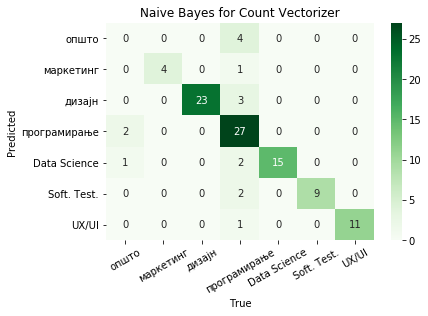

In [40]:
# Building the Naive Bayes Classifier
bayes_classifier = BernoulliNB()

bayes_classifier.fit(X_train, y_train)

bayes_pred = bayes_classifier.predict(X_test)

#Printing the classification report
bayes_class_report = classification_report(y_test, bayes_pred)
print(bayes_class_report)

#confusion_matrix()
plot_confusion_matrix(y_test, bayes_pred, cat_labels, 'Naive Bayes for Count Vectorizer')

              precision    recall  f1-score   support

           0       0.43      0.75      0.55         4
           1       0.75      0.60      0.67         5
           2       0.93      0.96      0.94        26
           3       0.81      0.90      0.85        29
           4       0.94      0.94      0.94        18
           5       1.00      0.64      0.78        11
           6       1.00      0.83      0.91        12

    accuracy                           0.87       105
   macro avg       0.84      0.80      0.81       105
weighted avg       0.89      0.87      0.87       105



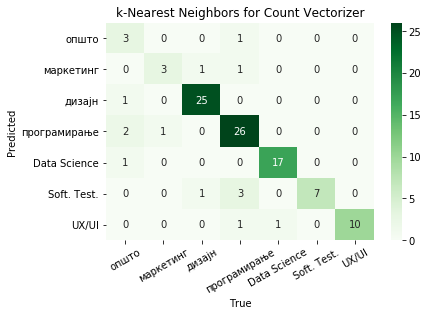

In [41]:
# Building the KNearest Neighbors Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3,
                                    weights='distance',
                                    p=2,
                                    n_jobs=-1)

knn_classifier.fit(X_train, y_train)

knn_pred = knn_classifier.predict(X_test)

#Printing the classification report
knn_class_report = classification_report(y_test, knn_pred)
print(knn_class_report)

#confusion_matrix()
plot_confusion_matrix(y_test, knn_pred, cat_labels, 'k-Nearest Neighbors for Count Vectorizer')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      1.00      1.00         5
           2       1.00      0.88      0.94        26
           3       0.74      1.00      0.85        29
           4       1.00      0.94      0.97        18
           5       1.00      0.82      0.90        11
           6       1.00      0.92      0.96        12

    accuracy                           0.90       105
   macro avg       0.82      0.79      0.80       105
weighted avg       0.89      0.90      0.89       105



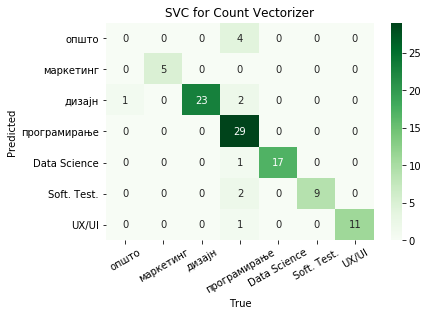

In [42]:
# Building the Support Vector Classifier
svc_classifier = SVC(kernel='rbf', random_state=10)

svc_classifier.fit(X_train, y_train)

svc_pred = svc_classifier.predict(X_test)

#Printing the classification report
svc_class_report = classification_report(y_test, svc_pred)
print(svc_class_report)

#confusion_matrix()
plot_confusion_matrix(y_test, svc_pred, cat_labels, 'SVC for Count Vectorizer')

## TFIDF Vectorizer Classifiers

In [43]:
# Splitting the data into train and test:

X_train, X_test, y_train, y_test = train_test_split(corpus_tfidif, cat_codes,
                                                    train_size=0.8,
                                                    random_state=10)

              precision    recall  f1-score   support

       општо       0.00      0.00      0.00         4
   маркетинг       1.00      1.00      1.00         5
      дизајн       1.00      0.92      0.96        26
програмирање       0.81      1.00      0.89        29
Data Science       1.00      0.94      0.97        18
 Soft. Test.       1.00      0.82      0.90        11
       UX/UI       1.00      1.00      1.00        12

    accuracy                           0.91       105
   macro avg       0.83      0.81      0.82       105
weighted avg       0.91      0.91      0.91       105



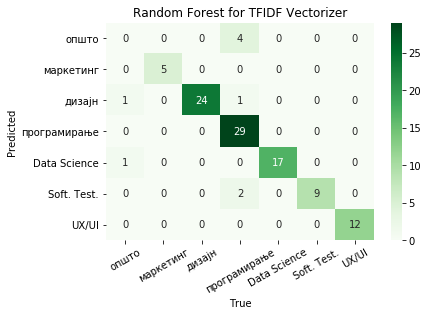

In [44]:
# Building the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=10)

rf_classifier.fit(X_train, y_train)

rf_pred = rf_classifier.predict(X_test)

#Printing the classification report
rf_class_report = classification_report(y_test, rf_pred, target_names=cat_labels)
print(rf_class_report)

#confusion_matrix()
plot_confusion_matrix(y_test, rf_pred, cat_labels, 'Random Forest for TFIDF Vectorizer')

              precision    recall  f1-score   support

       општо       0.00      0.00      0.00         4
   маркетинг       0.83      1.00      0.91         5
      дизајн       1.00      0.92      0.96        26
програмирање       0.79      0.90      0.84        29
Data Science       1.00      0.94      0.97        18
 Soft. Test.       0.90      0.82      0.86        11
       UX/UI       1.00      1.00      1.00        12

    accuracy                           0.89       105
   macro avg       0.79      0.80      0.79       105
weighted avg       0.88      0.89      0.88       105



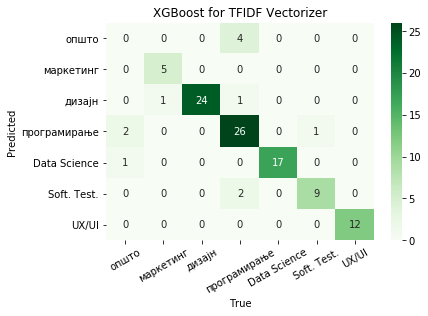

In [45]:
import xgboost as xgb

# Building the Random Forest Classifier
xgb_classifier = xgb.XGBClassifier()

xgb_classifier.fit(X_train, y_train)

xgb_pred = xgb_classifier.predict(X_test)

#Printing the classification report
xgb_class_report = classification_report(y_test, xgb_pred, target_names=cat_labels)
print(xgb_class_report)

#confusion_matrix()
plot_confusion_matrix(y_test, xgb_pred, cat_labels, 'XGBoost for TFIDF Vectorizer')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      0.80      0.89         5
           2       1.00      0.88      0.94        26
           3       0.68      0.93      0.78        29
           4       1.00      0.83      0.91        18
           5       1.00      0.82      0.90        11
           6       1.00      0.92      0.96        12

    accuracy                           0.85       105
   macro avg       0.81      0.74      0.77       105
weighted avg       0.87      0.85      0.85       105



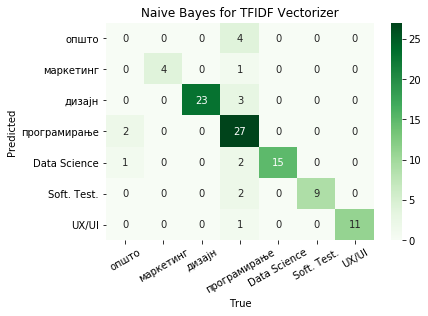

In [46]:
# Building the Naive Bayes Classifier
bayes_classifier = BernoulliNB()

bayes_classifier.fit(X_train, y_train)

bayes_pred = bayes_classifier.predict(X_test)

#Printing the classification report
bayes_class_report = classification_report(y_test, bayes_pred)
print(bayes_class_report)

#confusion_matrix()
plot_confusion_matrix(y_test, bayes_pred, cat_labels, 'Naive Bayes for TFIDF Vectorizer')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.67      0.80      0.73         5
           2       0.62      0.69      0.65        26
           3       0.73      0.76      0.75        29
           4       0.93      0.78      0.85        18
           5       1.00      0.64      0.78        11
           6       0.92      0.92      0.92        12

    accuracy                           0.72       105
   macro avg       0.70      0.65      0.67       105
weighted avg       0.76      0.72      0.73       105



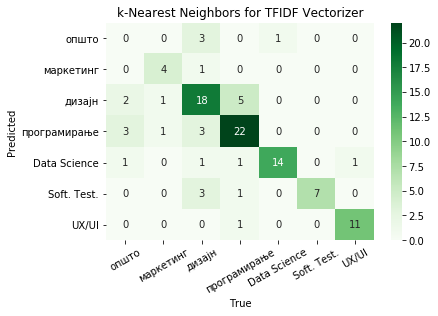

In [47]:
# Building the KNearest Neighbors Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5,
                                    weights='distance',
                                    p=2,
                                    n_jobs=-1)

knn_classifier.fit(X_train, y_train)

knn_pred = knn_classifier.predict(X_test)

#Printing the classification report
knn_class_report = classification_report(y_test, knn_pred)
print(knn_class_report)

#confusion_matrix()
plot_confusion_matrix(y_test, knn_pred, cat_labels, 'k-Nearest Neighbors for TFIDF Vectorizer')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.71      1.00      0.83         5
           2       0.96      0.92      0.94        26
           3       0.78      0.97      0.86        29
           4       1.00      0.94      0.97        18
           5       1.00      0.73      0.84        11
           6       1.00      0.92      0.96        12

    accuracy                           0.89       105
   macro avg       0.78      0.78      0.77       105
weighted avg       0.88      0.89      0.87       105



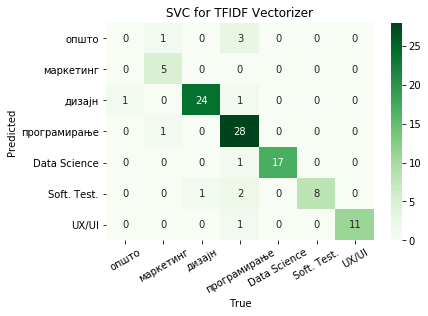

In [48]:
# Building the Support Vector Classifier
svc_classifier = SVC(kernel='rbf', random_state=10)

svc_classifier.fit(X_train, y_train)

svc_pred = svc_classifier.predict(X_test)

#Printing the classification report
svc_class_report = classification_report(y_test, svc_pred)
print(svc_class_report)

#confusion_matrix()
plot_confusion_matrix(y_test, svc_pred, cat_labels, 'SVC for TFIDF Vectorizer')

# НАДОЛУ Е ТЕСТ КОД

In [ ]:
print(qus[0])
print()
print(corpus[112:114])

In [ ]:
(corpus_vec[112].toarray() * corpus_vec[113].toarray()).sum()

In [ ]:
def print_red(a):
    print(corpus[a])

print_red(1)

In [ ]:
np.inner(corpus_vec[113].toarray()[0], corpus_vec[113].toarray()[0])

In [ ]:
from scipy.spatial.distance import dice, cosine, correlation

print('cosine = ', cosine(tq.toarray(), corpus_vec[89].toarray()))

print('correlation = ', correlation(tq.toarray(), corpus_vec[89].toarray()))

print('dice = ', dice(tq.toarray(), corpus_vec[89].toarray()))

In [ ]:
cosine_function = lambda a, b : np.inner(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
max(max(cosine_function(tq.toarray(), corpus_vec[89].toarray())))

In [ ]:
np.inner(tq.toarray(), corpus_vec[89].toarray())[0,0]

In [ ]:
a = tq
b = corpus_vec[89]
print(a)
print()
print(b)

In [ ]:
#c = a==b
a = tq
b = corpus_vec[89]
def dice_sim(a, b):
    a = a.toarray().flatten().astype(bool)
    b = b.toarray().flatten().astype(bool)
    return 2.0*np.logical_and(a, b).sum()/(a.sum() + b.sum())

dice_sim(a,a)

In [ ]:
dice(a.toarray(), b.toarray())

In [ ]:
dice([0, 1, 0], [0, 1, 0])

In [ ]:
dice_sim(np.asarray([0, 1, 0]), np.asarray([1, 0, 0]))

In [ ]:
p = np.array([0, 1, 0])
q = np.array([0, 1, 0])

print('cosine = ', cosine(p, q))

print('correlation = ', correlation(p, q))

print('dice = ', dice(p, q))

In [ ]:
def dice_sim_2(a, b):
    a = a.astype(bool)
    b = b.astype(bool)
    return 2.0*np.logical_and(a, b).sum()/(a.sum() + b.sum())

dice_sim_2(p, q)

In [ ]:
hasattr(a, ('toarray', 'flatten'))